### Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import itertools
import csv
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import anderson_ksamp
from ast import literal_eval

# Get data source
data_dir = 'data_process/12-06/'

# Read raw simulated data
simulated_raw_data = data_dir + '12-07-08-43-simulated_data_aa_wsr_rsr.csv'
# Read Human Data
human_data = data_dir + 'human_data_aa_wsr_rsr-14-40.csv'    # 'human_data_aa_wsr_rsr.csv'

after_process_file_name = 'after_process_1207_2params_03_simulated_data.csv'
after_PI_file_name = "afterPI_1207_2params_03_train_test_split_repeats_data_rep500.csv"
FIX_PERCEPT_FACT = True
FIX_WALK_FACT = False


# Convert to a dataframe
df_raw_sim = pd.read_csv(simulated_raw_data)
df_human = pd.read_csv(human_data)

# Identify the parameters that to be tuned later
WEIGHTS = 'weights'             # Ranges from 0-1
WALK_FACTORS = 'walk_factors'   # Ranges from 0-1
SIGN_FACTORS = 'sign_factors'   # Ranges from 0-1
# params = {
#     WEIGHT: None,
#     WALK_FACTOR: None,
#     SIGN_FACTOR: None,
# }
# Some other variables from the simulated file
STEPS = 'steps'
SIGN_READ = 'sign_read'
STEP_WISE_WALKING_POSITIONS = 'step_wise_walking_positions'
EXP_WALKING_POSITIONS = 'walking_positions'
STEP_WISE_WALKING_SPEEDS = 'step_wise_walking_speeds'
EXP_WALKING_SPEEDS = 'walking_speeds'
WALKING_SPEED_RATIOS = 'walking_speed_ratios'
STEP_WISE_ATTENTIONS = 'step_wise_attentions'
EXP_ATTENTION = 'attention_allocation'
ATTENTION_ON_SIGN = 'attention_on_sign'
ATTENTION_ON_OHMD = 'attention_on_ohmd'
SIGN_POSITIONS = 'sign_positions'
STEP_WISE_READING_RATIOS = 'step_wise_reading_ratios'
READING_SPEED_RATIOS = 'reading_speed_ratios'
EXP_READING_RATIOS = 'reading_ratios'
RECTANGLE_PATH_LENGTH = 'rectangle_path_length'
EP_LEN = 'ep_len'

SIGN = 'Sign'
ZERO_DOT_ONE = 0.1
WALK_FACTORS = 'walk_factors'
PERCEPTION_FACTORS = 'perception_factors'

# Determine the metrics
ATTENTION_ALLOCATION = 'attention_allocation'
WALKING_SPEED_RATIO = 'walking_speed_ratio'
READING_SPEED_RATIO = 'reading_speed_ratio'
metrics = [ATTENTION_ALLOCATION, WALKING_SPEED_RATIO, READING_SPEED_RATIO]

# Parameters that can be pre-defined
DEFAULT_WALK_FACTOR = 0.5
DEFAULT_SIGN_FACTOR = 0.5

# Number of signs in the experiment
NUM_SIGN_IN_EXP = 8

### Process the Raw Simulated Data

In [2]:
# Function to convert string representations of lists into actual lists
def literal_eval_col(col):
    return col.apply(literal_eval)
# def literal_eval_col(col):
#     return col.apply(lambda x: literal_eval(x) if not pd.isnull(x) else [])

# Round values
def round_nested_lists(column):
    rounded_column = []
    for row in column:
        if isinstance(row, list):
            rounded_row = [round(element, 1) if isinstance(element, float) else element for element in row]
            rounded_column.append(rounded_row)
        else:
            rounded_column.append(row)
    return rounded_column

# Process raw simulated data - main function - process data line by line
def process_raw_simulated_data(df_raw_sim):
    # Convert strings to lists in the whole df
    df_raw_sim.dropna(how='all', inplace=True)
    
    df_raw_sim[STEP_WISE_WALKING_POSITIONS] = literal_eval_col(df_raw_sim[STEP_WISE_WALKING_POSITIONS])
    df_raw_sim[STEP_WISE_WALKING_SPEEDS] = literal_eval_col(df_raw_sim[STEP_WISE_WALKING_SPEEDS])
    df_raw_sim[STEP_WISE_ATTENTIONS] = literal_eval_col(df_raw_sim[STEP_WISE_ATTENTIONS])
    df_raw_sim[SIGN_READ] = literal_eval_col(df_raw_sim[SIGN_READ])
    df_raw_sim[STEP_WISE_READING_RATIOS] = literal_eval_col(df_raw_sim[STEP_WISE_READING_RATIOS])
    rectangle_path_length = 60  # df_raw_sim.at[1, 'rectangle_path_length']
    
    #####################################################################
    # Get rid of the rows whose len(sign_read) < num_sign_in_exp
    df_read_eight_signs = df_raw_sim[df_raw_sim[SIGN_READ].apply(lambda x: len(x) >= NUM_SIGN_IN_EXP)]
#     df_read_eight_signs = df_read_eight_signs[df_read_eight_signs[WALK_FACTORS] == DEFAULT_WALK_FACTOR]
    
    #####################################################################
    empty_lists = [[] for _ in range(len(df_read_eight_signs))]
    
    # Creating a new column initialized with empty lists
    df_read_eight_signs[EXP_ATTENTION] = [[] for _ in range(len(df_read_eight_signs))]
    df_read_eight_signs[EXP_WALKING_SPEEDS] = [[] for _ in range(len(df_read_eight_signs))]
    df_read_eight_signs[EXP_READING_RATIOS] = [[] for _ in range(len(df_read_eight_signs))]
    # Iterate over each row
    for index, row in df_read_eight_signs.iterrows():
        # Find the index where the value in 'step_wise_walking_positions' first exceeds 60
        index_exceeding_60 = next((i for i, val in enumerate(row[STEP_WISE_WALKING_POSITIONS]) if val > rectangle_path_length), None)
        
        # If such an index is found, slice 'step_wise_attention_allocation' up to that index
        if index_exceeding_60 is not None:
            df_read_eight_signs.at[index, EXP_ATTENTION] = row[STEP_WISE_ATTENTIONS][:index_exceeding_60]
            df_read_eight_signs.at[index, EXP_WALKING_SPEEDS] = row[STEP_WISE_WALKING_SPEEDS][:index_exceeding_60]
            df_read_eight_signs.at[index, EXP_READING_RATIOS] = row[STEP_WISE_READING_RATIOS][:index_exceeding_60]
        else:
            # If no value exceeds 60, the column remains an empty list for this row
            df_read_eight_signs.at[index, EXP_ATTENTION] = []
            df_read_eight_signs.at[index, EXP_WALKING_SPEEDS] = []
            df_read_eight_signs.at[index, EXP_READING_RATIOS] = []
    
    #####################################################################
    # Get indexes where the attention is on the sign, which are on the OHMD
    # Initialize the new columns with empty lists
    df_read_eight_signs[ATTENTION_ON_SIGN] = [[] for _ in range(len(df_read_eight_signs))]
    df_read_eight_signs[ATTENTION_ON_OHMD] = [[] for _ in range(len(df_read_eight_signs))]
    # Initialize the new column with empty lists
    df_read_eight_signs[READING_SPEED_RATIOS] = [[] for _ in range(len(df_read_eight_signs))]
    # Iterate over each row
    for index, row in df_read_eight_signs.iterrows():
        # Lists to store attention data
        attention_on_sign = []
        attention_on_ohmd = []
        reading_speed_ratios = []

        # Check each item in the 'EXP_ATTENTION' list
        for i, attention_item in enumerate(row[EXP_ATTENTION]):
            if attention_item != 'Sign':
                attention_on_ohmd.append(attention_item)
                # Append the corresponding item from 'EXP_READING_RATIOS'
                reading_speed_ratios.append(row[EXP_READING_RATIOS][i])
            else:
                attention_on_sign.append(attention_item)         

        # Assign the lists to the new columns
        df_read_eight_signs.at[index, ATTENTION_ON_SIGN] = attention_on_sign
        df_read_eight_signs.at[index, ATTENTION_ON_OHMD] = attention_on_ohmd
        df_read_eight_signs.at[index, READING_SPEED_RATIOS] = reading_speed_ratios
        
    #####################################################################
    df_read_eight_signs[WALKING_SPEED_RATIOS] = [[] for _ in range(len(df_read_eight_signs))]
    # Iterate over each row
    for index, row in df_read_eight_signs.iterrows():
        # Filter walking speeds greater than 0.1
        walking_speeds_above_threshold = [speed for speed in row[EXP_WALKING_SPEEDS] if speed > ZERO_DOT_ONE]
        # Assign the filtered speeds to the new column
        df_read_eight_signs.at[index, WALKING_SPEED_RATIOS] = walking_speeds_above_threshold
    
    #####################################################################
    df_read_eight_signs[ATTENTION_ALLOCATION] = 0
    df_read_eight_signs[WALKING_SPEED_RATIO] = 0
    df_read_eight_signs[READING_SPEED_RATIO] = 0
    
    # Iterate over each row to calculate the ratios
    for index, row in df_read_eight_signs.iterrows():
        # Calculate the attention allocation ratio
        if len(row[ATTENTION_ON_OHMD]) > 0:
            df_read_eight_signs.at[index, ATTENTION_ALLOCATION] = len(row[ATTENTION_ON_SIGN]) / (len(row[ATTENTION_ON_OHMD]) + len(row[ATTENTION_ON_SIGN]))
        else:
            df_read_eight_signs.at[index, ATTENTION_ALLOCATION] = float('inf')  # or some other value to indicate undefined

        # Calculate the walking speed ratio (average)
        if row[WALKING_SPEED_RATIOS]:
            df_read_eight_signs.at[index, WALKING_SPEED_RATIO] = sum(row[WALKING_SPEED_RATIOS]) / len(row[WALKING_SPEED_RATIOS])

        # Calculate the reading speed ratio (average)
        if row[READING_SPEED_RATIOS]:
            df_read_eight_signs.at[index, READING_SPEED_RATIO] = sum(row[READING_SPEED_RATIOS]) / len(row[READING_SPEED_RATIOS])
        
    #####################################################################
    # Write the DataFrame to a CSV file
    df_read_eight_signs.to_csv(data_dir+ after_process_file_name, index=False)
    
    return df_read_eight_signs

    

In [3]:
df_sim_after_raw_process = process_raw_simulated_data(df_raw_sim=df_raw_sim)

C:\Users\91584\AppData\Local\Temp\ipykernel_29592\1187694914.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_read_eight_signs[EXP_ATTENTION] = [[] for _ in range(len(df_read_eight_signs))]
C:\Users\91584\AppData\Local\Temp\ipykernel_29592\1187694914.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_read_eight_signs[EXP_WALKING_SPEEDS] = [[] for _ in range(len(df_read_eight_signs))]
C:\Users\91584\AppData\Local\Temp\ipykernel_29592\1187694914.py:41: SettingWithCopyWarning: 
A value is trying to

### Parameter Inference: Attention Allocation (s), Walking Speed Ratio (%), Reading Speed Ratio (%)

In [4]:
# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
#     return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))
    return abs(sim_data - human_data)

# Find the best parameter
def find_best_params(df_sim, mean_train_aa, mean_train_wsr, mean_train_rsr):
    
    # In case if need to decrease the number of parameters.
    if FIX_PERCEPT_FACT:
        df_sim = df_sim[df_sim[PERCEPTION_FACTORS] == 0.3]
        if FIX_WALK_FACT:
            df_sim = df_sim[df_sim[WALK_FACTORS] == 0.5]
    
    unique_params = df_sim[[WEIGHTS, WALK_FACTORS, PERCEPTION_FACTORS]].drop_duplicates()
    min_cost = float('inf')
    best_params = None

    for index, row in unique_params.iterrows():
        filtered_df = df_sim[
            (df_sim[WEIGHTS] == row[WEIGHTS]) &
            (df_sim[WALK_FACTORS] == row[WALK_FACTORS]) &
            (df_sim[PERCEPTION_FACTORS] == row[PERCEPTION_FACTORS])
        ]
        
        # Get simulated data
        sim_aa = filtered_df[ATTENTION_ALLOCATION].values[0]
        sim_wsr = filtered_df[WALKING_SPEED_RATIO].values[0]
        sim_rsr = filtered_df[READING_SPEED_RATIO].values[0]
        
        # Get human data
        human_aa = mean_train_aa
        human_wsr = mean_train_wsr
        human_rsr = mean_train_rsr
        
        # Compute the cost
        cost_aa = compute_cost(sim_aa, human_aa)
        cost_wsr = compute_cost(sim_wsr, human_wsr)
        cost_rsr = compute_cost(sim_rsr, human_rsr)
        
        total_cost = cost_aa + cost_wsr + cost_rsr

        if total_cost < min_cost:
            min_cost = total_cost
            best_params = row
    
    # Given the best parameters and the dataframe, return the simulated results
    sim_aa_best = []
    sim_wsr_best = []
    sim_rsr_best = []
    
    # Extract the simulated steps and error for each layout based on best_params
    filtered_df = df_sim[
        (df_sim[WEIGHTS] == best_params[WEIGHTS]) &
        (df_sim[WALK_FACTORS] == best_params[WALK_FACTORS]) &
        (df_sim[PERCEPTION_FACTORS] == best_params[PERCEPTION_FACTORS])
    ]

    sim_aa_best.append(filtered_df[ATTENTION_ALLOCATION].values[0])
    sim_wsr_best.append(filtered_df[WALKING_SPEED_RATIO].values[0])
    sim_rsr_best.append(filtered_df[READING_SPEED_RATIO].values[0])

    return best_params, min_cost, sim_aa_best, sim_wsr_best, sim_rsr_best

In [5]:
%%time

num_iterations = 2000
all_costs = []
all_best_params = []

# # Lists to store sim-to-real mapping ratios for each iteration
# sim_to_real_ratios_duration = []
# sim_to_real_ratios_error = []

sim_aas = []
sim_wsrs = []
sim_rsrs = []
human_train_aas = []
human_train_wsrs = []
human_train_rsrs = []
human_test_aas = []
human_test_wsrs = []
human_test_rsrs = []
human_train_aas_details = []
human_train_wsrs_details = []
human_train_rsrs_details = []
human_test_aas_details = []
human_test_wsrs_details = []
human_test_rsrs_details = []

# Get human data from the dataframe
df_human_aa = df_human[ATTENTION_ALLOCATION]
df_human_wsr = df_human[WALKING_SPEED_RATIO]
df_human_rsr = df_human[READING_SPEED_RATIO]

for i in range(num_iterations):
    # Number of participants
#     num_participants = len(human_duration_data[0])
    num_participants = len(df_human)

    # Generate list of indices based on participants
    indices = list(range(num_participants))

    # Split indices to ensure consistency
    train_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=i)  
    # using i as the seed for reproducibility

    # Use these indices to split the human data consistently across participants
    def split_data_based_on_indices(data, train_indices, test_indices):
        train_set = [data[i] for i in train_indices]
        test_set = [data[i] for i in test_indices]
        return train_set, test_set

    # Split human aa data
    train_aas, test_aas = split_data_based_on_indices(df_human_aa, train_indices, test_indices)

    # Split human wsr data
    train_wsrs, test_wsrs = split_data_based_on_indices(df_human_wsr, train_indices, test_indices)
    
    # Split human rsr data
    train_rsrs, test_rsrs = split_data_based_on_indices(df_human_rsr, train_indices, test_indices)

    # Compute mean for the training and test sets
    mean_train_aa = np.mean(train_aas)
    mean_train_wsr = np.mean(train_wsrs)
    mean_train_rsr = np.mean(train_rsrs)
    mean_test_aa = np.mean(test_aas)
    mean_test_wsr = np.mean(test_wsrs)
    mean_test_rsr = np.mean(test_rsrs)

    # Using the function to find the best parameters
    best_params, _, sim_best_aas, sim_best_wsrs, sim_best_rsrs = find_best_params(df_sim_after_raw_process, mean_train_aa, mean_train_wsr, mean_train_wsr)
    all_best_params.append(best_params)
    
#     # Get sim to real mapping ratios for duration and error metrics respectively
#     # Compute sim-to-real ratio for the current iteration
#     sim_to_real_ratio_duration = sum(mean_train_duration) / sum(sim_durations)
#     sim_to_real_ratio_error = sum(mean_train_error) / sum(sim_errors)
    
    # Store the computed ratios
    for sim_best_aa, sim_best_wsr, sim_best_rsr, test_aa, test_wsr, test_rsr, train_aa, train_wsr, train_rsr in zip(
        sim_best_aas, 
        sim_best_wsrs,
        sim_best_rsrs,
        test_aas, 
        test_wsrs, 
        test_rsrs,
        train_aas, 
        train_wsrs,
        train_rsrs,
    ):
        sim_aas.append(sim_best_aa)
        sim_wsrs.append(sim_best_wsr)
        sim_rsrs.append(sim_best_rsr)
        human_train_aas.append(np.mean(train_aa))
        human_train_wsrs.append(np.mean(train_wsr))
        human_train_rsrs.append(np.mean(train_rsr))
        human_test_aas.append(np.mean(test_aa))
        human_test_wsrs.append(np.mean(test_wsr))
        human_test_rsrs.append(np.mean(test_rsr))
        human_train_aas_details.append(train_aa)
        human_train_wsrs_details.append(train_wsr)
        human_train_rsrs_details.append(train_rsr)
        human_test_aas_details.append(test_aa)
        human_test_wsrs_details.append(test_wsr)
        human_test_rsrs_details.append(test_rsr)

CPU times: total: 21min 42s
Wall time: 22min 16s


In [6]:
# Open a CSV file in write mode
best_params_file_name = data_dir + after_PI_file_name

# Copy for reproducibility
sim_aas_cp = copy.deepcopy(sim_aas)
sim_wsrs_cp = copy.deepcopy(sim_wsrs) 
sim_rsrs_cp = copy.deepcopy(sim_rsrs)
human_train_aas_cp = copy.deepcopy(human_train_aas)
human_train_wsrs_cp = copy.deepcopy(human_train_wsrs)
human_train_rsrs_cp = copy.deepcopy(human_train_rsrs) 
human_test_aas_cp = copy.deepcopy(human_test_aas)
human_test_wsrs_cp = copy.deepcopy(human_test_wsrs)
human_test_rsrs_cp = copy.deepcopy(human_test_rsrs)

SIM_AAS = 'sim_aas'
SIM_WSRS = 'sim_wsrs'
SIM_RSRS = 'sim_rsrs'
HUM_TRAIN_AAS = 'hum_train_aas'
HUM_TRAIN_WSRS = 'hum_train_wsrs'
HUM_TRAIN_RSRS = 'hum_train_rsrs'
HUM_TEST_AAS = 'hum_test_aas'
HUM_TEST_WSRS = 'hum_test_wsrs'
HUM_TEST_RSRS = 'hum_test_rsrs'

# Write
with open(best_params_file_name, "w", newline='') as csvfile:
    # Initialize the CSV writer
    writer = csv.writer(csvfile)

    # Write the headers
    headers = [
        WEIGHTS,
        WALK_FACTORS,
        PERCEPTION_FACTORS,
        SIM_AAS,
        SIM_WSRS,
        SIM_RSRS,
        HUM_TRAIN_AAS,
        HUM_TRAIN_WSRS,
        HUM_TRAIN_RSRS,
        HUM_TEST_AAS,
        HUM_TEST_WSRS,
        HUM_TEST_RSRS,
    ]
    writer.writerow(headers)
    
    # Write data for each layout
    for i, best_param in enumerate(all_best_params):
        row = [
            best_param[0],  # weights
            best_param[1],  # walk_factors
            best_param[2],  # perception_factors
            sim_aas_cp[i],
            sim_wsrs_cp[i],
            sim_rsrs_cp[i],
            human_train_aas_cp[i],
            human_train_wsrs_cp[i],
            human_train_rsrs_cp[i],
            human_test_aas_cp[i],
            human_test_wsrs_cp[i],
            human_test_rsrs_cp[i],
        ]
        writer.writerow(row)

### Plot

In [7]:
# Calculate STD
def std(data):
    return np.std(data)

# Function to adjust y-limit
def adjust_ylim(ax, mean, std):
#     y_max = max([mean + std for mean, std in zip(means, stds)])
    y_max = mean + std
    ax.set_ylim(0, y_max * 1.15)  # Adding a bit of margin to the top
    
# Get data
# human test batch data
mean_human_test_aas = np.mean(human_test_aas_cp) * 100
std_human_test_aas = std(human_test_aas_cp) * 100
mean_human_test_wsrs = np.mean(human_test_wsrs_cp) * 100
std_human_test_wsrs = std(human_test_wsrs_cp) * 100
mean_human_test_rsrs = np.mean(human_test_rsrs_cp) * 100
std_human_test_rsrs = std(human_test_rsrs_cp) * 100
# parameter inferenced batch data
mean_sim_aas = np.mean(sim_aas_cp) * 100
std_sim_aas = std(sim_aas_cp) * 100
mean_sim_wsrs = np.mean(sim_wsrs_cp) * 100
std_sim_wsrs = std(sim_wsrs_cp) * 100
mean_sim_rsrs = np.mean(sim_rsrs_cp) * 100
std_sim_rsrs = std(sim_rsrs_cp) * 100

In [8]:
# Plot
x = np.array([0.5])
width = 0.2

def plot_bars(mean_human_test, mean_sim, std_human_test, std_sim, ylabel_text, savefig_name, has_legend=True):
    fig, ax = plt.subplots(figsize=(6, 4))
    rects1 = ax.bar(x - width/2, mean_human_test, width, label='Human Data', color='blue', yerr=std_human_test, capsize=10)
    rects2 = ax.bar(x + width/2, mean_sim, width, label='Simulated Data', color='green', yerr=std_sim_aas, capsize=10)
    
    for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        std1 = std_human_test
        std2 = std_sim

        ax.annotate(f"{height1:.2f}\n({std1:.2f})", 
                   (rect1.get_x() + rect1.get_width() / 2., height1 + std1 + 0.05),
                   ha='center', va='bottom')
        ax.annotate(f"{height2:.2f}\n({std2:.2f})", 
                   (rect2.get_x() + rect2.get_width() / 2., height2 + std2 + 0.05),
                   ha='center', va='bottom')
    
    ax.set_ylabel(ylabel_text, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels('', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis
    
    if has_legend == True:
        ax.legend(fontsize=15)
    
    adjust_ylim(ax, mean_human_test + mean_sim, std_human_test + std_sim)
    
    ax.tick_params(axis='both', labelsize=12)
    
    fig.savefig(data_dir + savefig_name, dpi=300)
    plt.close(fig)

In [9]:
plot_bars(mean_human_test_aas, mean_sim_aas, std_human_test_aas, std_sim_aas, 'Sign Attention Allocation (%)', 'study4attentionallocation.png')
plot_bars(mean_human_test_wsrs, mean_sim_wsrs, std_human_test_wsrs, std_sim_wsrs, 'Walking Speed Ratio (%)', 'study4walkingspeedratio.png', has_legend=False)
plot_bars(mean_human_test_rsrs, mean_sim_rsrs, std_human_test_rsrs, std_sim_rsrs, 'Reading Speed Ratio (%)', 'study4readingspeedratio.png', has_legend=False)

### Stastical Analysis: RMSE

In [10]:
# RMSE computation function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

# Compute RMSE for durations and errors for each layout
rmse_durations_layouts = {}
rmse_errors_layouts = {}

rmse_aas = compute_rmse(human_test_aas_cp, sim_aas_cp)
rmse_wsrs = compute_rmse(human_test_wsrs_cp, sim_wsrs_cp)
rmse_rsrs = compute_rmse(human_test_rsrs_cp, sim_rsrs_cp)

# Display results
print(f"Average RMSE for attention allocation is: {rmse_aas:.4f}")
print(f"Average RMSE for walking speed ratio is: {rmse_wsrs:.4f}")
print(f"Average RMSE for reading speed ratio is: {rmse_rsrs:.4f}")

Average RMSE for attention allocation is: 0.0292
Average RMSE for walking speed ratio is: 0.1092
Average RMSE for reading speed ratio is: 0.1035


### Stastical Analysis: Anderson-Darling two-sample test

In [11]:
# Performing the Anderson-Darling two-sample test
ad_aas = anderson_ksamp([human_test_aas_cp, sim_aas_cp])
ad_wsrs = anderson_ksamp([human_test_wsrs_cp, sim_wsrs_cp])
ad_rsrs = anderson_ksamp([human_test_rsrs_cp, sim_rsrs_cp])
print(f'Attention allocation: {ad_aas}, \nWalking Speed Ratio: {ad_wsrs}, \nReading Speed Ratio: {ad_rsrs}')

Attention allocation: Anderson_ksampResult(statistic=446.797999732033, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001), 
Walking Speed Ratio: Anderson_ksampResult(statistic=473.93911503082234, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001), 
Reading Speed Ratio: Anderson_ksampResult(statistic=665.2145246323273, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


C:\Users\91584\AppData\Local\Temp\ipykernel_29592\874954781.py:2: UserWarning: p-value floored: true value smaller than 0.001
  ad_aas = anderson_ksamp([human_test_aas_cp, sim_aas_cp])
C:\Users\91584\AppData\Local\Temp\ipykernel_29592\874954781.py:3: UserWarning: p-value floored: true value smaller than 0.001
  ad_wsrs = anderson_ksamp([human_test_wsrs_cp, sim_wsrs_cp])
C:\Users\91584\AppData\Local\Temp\ipykernel_29592\874954781.py:4: UserWarning: p-value floored: true value smaller than 0.001
  ad_rsrs = anderson_ksamp([human_test_rsrs_cp, sim_rsrs_cp])


### Draw the parameter distribution

In [12]:
df_params = pd.read_csv(best_params_file_name)
weights_data = df_params[WEIGHTS]
walk_factors_data = df_params[WALK_FACTORS]
perception_factors_data = df_params[PERCEPTION_FACTORS]

In [13]:
def plot_params_distr(data, name):
    # Normalizing the data (if necessary)
    scaler = MinMaxScaler(feature_range=(0, 1))
    column_data_normalized = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

    # Plotting the distribution
    plt.hist(column_data_normalized, bins=50, alpha=0.7)
    plt.title(f'{name} Distribution')
    plt.xlabel('Normalized Value')
    plt.ylabel('Frequency')
    plt.show()

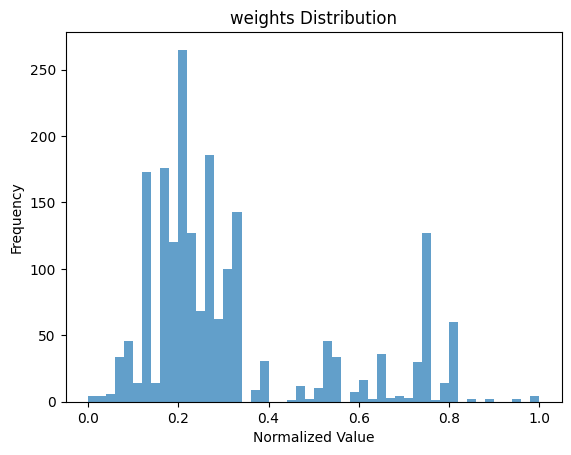

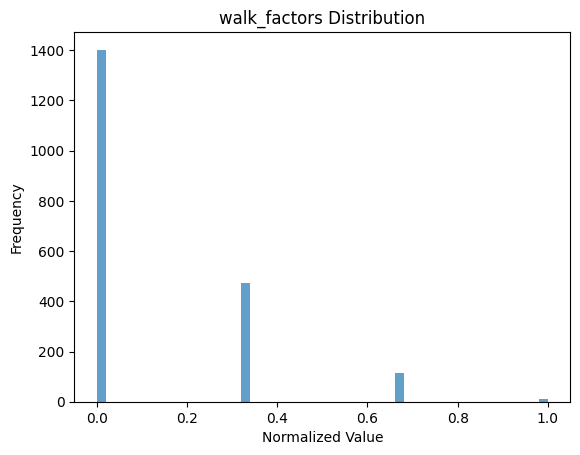

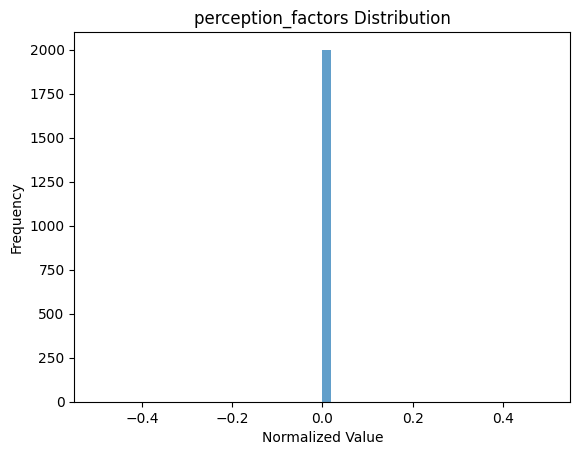

In [14]:
plot_params_distr(data=weights_data, name=WEIGHTS)
plot_params_distr(data=walk_factors_data, name=WALK_FACTORS)
plot_params_distr(data=perception_factors_data, name=PERCEPTION_FACTORS)

### Reading Resumption Time Cost (s), Error Rate (%).
Done in the neighbor jupyter-notebook file.